In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from functions import shift_atoms_p63, transform_list_hkl_p63_p65, get_structure_factors, get_mode_amplitudes_p63
from matplotlib.markers import MarkerStyle
from tqdm import tqdm
from time import time

%config InlineBackend.figure_format = 'svg' # make figures appears in .svg style


num_threads = 2  

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

print(f"Using {num_threads} threads for intra-op and inter-op parallelism.")


Using 2 threads for intra-op and inter-op parallelism.


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [7]:
def fun_tf(x, pars):
    """
    Fast computation of structure factors with parameter-dependent structure.
        # Get modified structure
    modified_struct = shift_atoms_p65(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    return intensity / tf.reduce_max(intensity)
    """
    # Get modified structure
    modified_struct = shift_atoms_p63(*pars)
    neg_h = tf.stack([-x[:, 0], x[:, 1], x[:, 2]], axis=1)
    x_combined = tf.concat([x, neg_h], axis=0)  # Shape [2N, 3]

    x_combined = transform_list_hkl_p63_p65(x_combined)

    # Get structure factors
    sf_combined = get_structure_factors(x_combined, modified_struct)
    # Compute intensity
    # Split and compute intensity
    sf_hkl = sf_combined[:tf.shape(x)[0]]
    sf_neg_k = sf_combined[tf.shape(x)[0]:]
    
    intensity = (tf.abs(sf_hkl) + tf.abs(sf_neg_k)) ** 2
    w = tf.constant(0.00159, dtype=tf.float32)  # Debye-Waller factor is 0.00159
    qnorms = tf.norm(tf.cast(x_combined[:tf.shape(x)[0]], tf.float32), axis=1)
    # qnorms = tf.reshape(qnorms, (-1, 1))  # Reshape to match the shape of intensity
    intensity = intensity * tf.exp(-w * qnorms ** 2)  # Apply Debye-Waller factor
    return intensity / tf.reduce_max(intensity)


In [8]:
# Example input data
x_example = np.array([[0.25, 0.25, 1.5], [-0.25, 0.25, 1.5], [0.75, 0.25, 1.5], [-0.75, 0.25, 1.5] ], dtype=np.float32)
# Convert to TensorFlow tensors
x_example_tf = tf.convert_to_tensor(x_example)

pars_example = np.array([-0.00001487,-0.00295681, 0.00002191, -0.00001591, 0.00854070, 0.00852493], dtype=np.float32)

pars_example_tf = tf.convert_to_tensor(pars_example)

# Call the function with the example data
result = fun_tf(x_example_tf, pars_example_tf)
# Print the result
tf.print("example hkl:", x_example_tf)
tf.print("example pars:", pars_example_tf)
tf.print("Result shape:", tf.shape(result))
tf.print("Result:", result)

example hkl: [[0.25 0.25 1.5]
 [-0.25 0.25 1.5]
 [0.75 0.25 1.5]
 [-0.75 0.25 1.5]]
example pars: [-1.487e-05 -0.00295681 2.191e-05 -1.591e-05 0.0085407 0.00852493]
Result shape: [4]
Result: [0.989338219 0.990518749 0.996428907 1]


Sample the model parameters (fitting parameters)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths

In [9]:
experimental_data = pd.read_csv('/home/mariolb/repos/CrystalClearFit/DistortionFit/combined.csv')
"""
# reduce data to l in [0.5, 1.5, 2.5, 3.5, 4.5 ]
experimental_data = experimental_data[
    (experimental_data["l"] == 0.5) |
    (experimental_data["l"] == 1.5) |
    (experimental_data["l"] == 2.5) |
    (experimental_data["l"] == 3.5) |
    (experimental_data["l"] == 4.5)
]
"""

hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
print(experimental_data.shape)
print(hkl_list[0:5])

(910, 17)
tf.Tensor(
[[-0.5 -0.5  0. ]
 [ 0.5 -0.5  0. ]
 [-1.5 -0.5  0. ]
 [ 1.5 -0.5  0. ]
 [-2.5 -0.5  0. ]], shape=(5, 3), dtype=float32)


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

In [10]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list
labels = experimental_data["intensity_exp"].tolist()
labels = tf.convert_to_tensor(labels, dtype=tf.float32)
vol_err = experimental_data["intensity_exp_err"].tolist()
labels_err = []
for label, err in zip(labels, vol_err):
    if err > 0:
        labels_err.append((label/err)*0.001)  # Inverse error
    else:
        labels_err.append(0.0255)  # Handle zero intensity case with no err
labels_err = tf.convert_to_tensor(labels_err, dtype=tf.float32)
combined_labels = tf.stack([labels, labels_err], axis=1)
print("Max label err:", np.max(labels_err))
print("Features shape:", features.shape)
print("Labels shape:", combined_labels.shape)
print(combined_labels[0:5])


Max label err: 0.16607162
Features shape: (910, 3)
Labels shape: (910, 2)
tf.Tensor(
[[0.         0.0255    ]
 [0.         0.0255    ]
 [0.01955206 0.01384054]
 [0.01955206 0.01384054]
 [0.10275436 0.00738237]], shape=(5, 2), dtype=float32)


Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [11]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_par_value=0.01, **kwargs):
        super().__init__(**kwargs)
        self.max_par_value = max_par_value

    def build(self, input_shape):
        # Define six trainable parameters
        self.a = self.add_weight(name='a', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.b = self.add_weight(name='b', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.c = self.add_weight(name='c', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.d = self.add_weight(name='d', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.e = self.add_weight(name='e', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.f = self.add_weight(name='f', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the [-0.1, 0.1] range
        a = self.max_par_value * tf.tanh(self.a)
        b = self.max_par_value * tf.tanh(self.b)
        c = self.max_par_value * tf.tanh(self.c)
        d = self.max_par_value * tf.tanh(self.d)
        e = self.max_par_value * tf.tanh(self.e)
        f = self.max_par_value * tf.tanh(self.f)
        
        # Call your fun_tf function to get the output
        return fun_tf(inputs, [a, b, c, d, e, f])

    def compute_output_shape(self, input_shape):
        # If the input has shape (None, 3), return the same shape
        return (input_shape[0], 1)  # This assumes your output is of shape (None, 1)


Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [12]:
"""
# R-Score based on intensity
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(y_true)
"""
    
# mean squared error
class PerSampleMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__(reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        squared_error = tf.square(y_true - y_pred)
        per_sample_mse = tf.reduce_mean(squared_error, axis=-1)
        return per_sample_mse  # shape (batch_size,)

class MSE_weighted(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Assume y_true = [labels, errors]
        labels = y_true[:, 0]
        weights = y_true[:, 1]

        mse = tf.square(labels - y_pred)
        return tf.reduce_sum(mse * weights) / tf.reduce_sum(weights)


# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    labels = y_true[:, 0]
    return tf.reduce_sum(tf.abs(labels - y_pred)) / tf.reduce_sum(labels)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

Learning rate: 0.008
Final loss: 3.935e-02
Iteration 1 - New best loss: 3.935e-02 (R-factor: 1.065e+00)
Final loss: 3.789e-02
Iteration 2 - New best loss: 3.789e-02 (R-factor: 1.044e+00)
Final loss: 4.623e-02
Final loss: 3.910e-02
Final loss: 4.746e-02
Final loss: 3.639e-02
Iteration 6 - New best loss: 3.639e-02 (R-factor: 9.892e-01)
Final loss: 3.796e-02
Final loss: 3.638e-02
Iteration 8 - New best loss: 3.638e-02 (R-factor: 9.765e-01)
Final loss: 3.796e-02
Final loss: 3.616e-02
Iteration 10 - New best loss: 3.616e-02 (R-factor: 1.076e+00)
Final loss: 3.638e-02
Final loss: 3.734e-02
Final loss: 3.712e-02
Final loss: 3.792e-02
Final loss: 3.722e-02
Final loss: 3.796e-02
Final loss: 3.725e-02
Final loss: 3.889e-02
Final loss: 3.776e-02
Final loss: 3.636e-02
time elapsed: 97.45 seconds
With 61.56776333012071 iterations per second


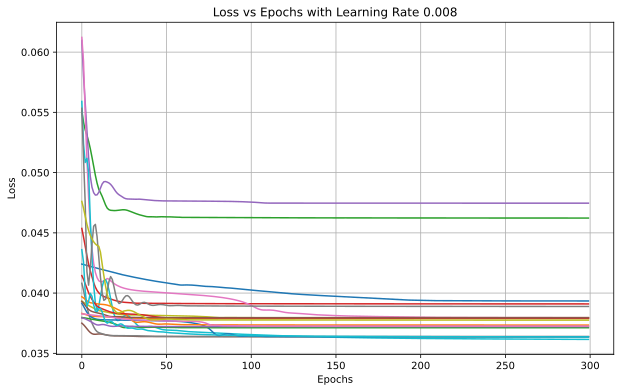

Learning rate: 0.01
Final loss: 3.715e-02
Iteration 1 - New best loss: 3.715e-02 (R-factor: 1.004e+00)
Final loss: 3.836e-02
Final loss: 3.837e-02
Final loss: 3.833e-02
Final loss: 3.909e-02
Final loss: 3.804e-02
Final loss: 3.789e-02
Final loss: 3.768e-02
Final loss: 3.765e-02
Final loss: 3.933e-02
Final loss: 3.639e-02
Iteration 11 - New best loss: 3.639e-02 (R-factor: 9.898e-01)
Final loss: 3.804e-02
Final loss: 3.775e-02
Final loss: 3.833e-02
Final loss: 3.895e-02
Final loss: 3.646e-02
Final loss: 3.789e-02
Final loss: 3.796e-02
Final loss: 3.636e-02
Iteration 19 - New best loss: 3.636e-02 (R-factor: 9.755e-01)
Final loss: 3.717e-02
time elapsed: 94.82 seconds
With 63.275277805455005 iterations per second


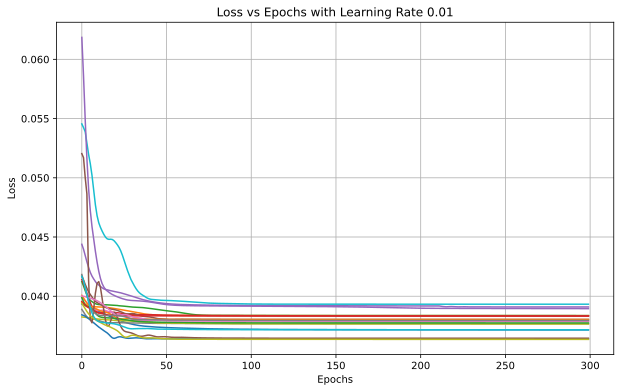

In [13]:
lr = [8e-3, 1e-2]
best_pars_overall = None
best_rf_overall = np.inf
best_loss_overall = []
for learning_rate in lr:
    time_start = time()
    print(f"Learning rate: {learning_rate}")
    optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)


    max_par_value = 0.08
    n_epochs = 300
    histories = []
    n_iter = 20

    min_loss = np.inf
    best_pars = None

    # List to store the loss values for each epoch
    all_losses = []


    for i in range(n_iter):
        # Create the model
        inputs = tf.keras.Input(shape=(n_dim,))
        outputs = FunAsLayer(max_par_value)(inputs)
        model = tf.keras.Model(inputs, outputs)

        # Compile the model with the custom loss function and metric
        model.compile(
            optimizer=optim,
            loss=MSE_weighted(), # MSE_weighted() if using errors
            metrics=[r_factor_metric]
        )
        
        history = model.fit(
        x=features,
        y=combined_labels,  # replace with combined_labels if using errors
        batch_size = features.shape[0], # Use a smaller batch size features.shape[0]
        epochs=n_epochs,
        verbose=0,
        shuffle=True, # not sure whether this matters
        # callbacks=[cb]
        )

        histories.append(history)
        all_losses.append(history.history['loss'])
        # Check final loss
        final_loss = history.history['loss'][-1]
        curren_model_pars = [max_par_value * tf.tanh(model.layers[-1].get_weights()[i]) for i in range(6)]
        print(f"Final loss: {final_loss:.3e}")
        '''
        print(f"Best parameters for iteration {i+1}:")
        for j, par in enumerate(curren_model_pars):
            print(f"Parameter {j+1}: {par.numpy():.4f}")
        '''

        if final_loss < min_loss:
            # Update best model parameters
            best_model_pars = [max_par_value * tf.tanh(model.layers[-1].get_weights()[i]) for i in range(6)]
            min_loss = final_loss
            rf = r_factor_metric(combined_labels, fun_tf(features, best_model_pars))
            print(f"Iteration {i+1} - New best loss: {min_loss:.3e} (R-factor: {rf:.3e})")

    if min_loss < best_rf_overall:
        best_rf_overall = min_loss
        best_pars_overall = best_model_pars
        best_loss_overall = all_losses
    print(f"time elapsed: {time() - time_start:.2f} seconds")
    print(f"With {n_epochs*n_iter /(time() - time_start)} iterations per second")
    # Plotting the loss values
    plt.figure(figsize=(10, 6))

    # Plot the loss values for each iteration
    for i, loss_values in enumerate(all_losses):
        plt.plot(loss_values, label=f'Iteration {i+1}')

    plt.title(f'Loss vs Epochs with Learning Rate {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.legend()
    plt.grid(True)
    plt.show()


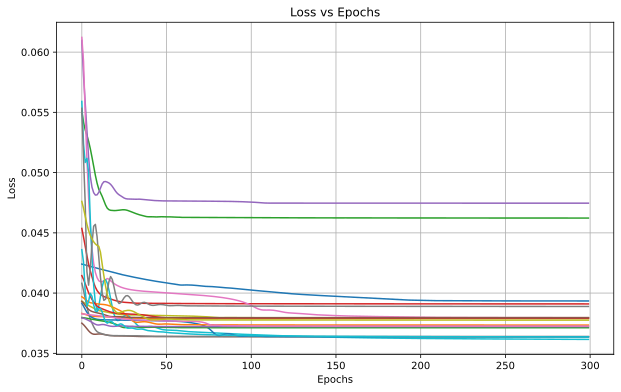

In [14]:
all_losses = best_loss_overall
best_model_pars = best_pars_overall
min_loss = best_rf_overall

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.grid(True)
plt.show()

In [15]:

# Print the best model parameters
print("Best model parameters:")
for i, par in enumerate(best_model_pars):
    print(f"Parameter {i+1}: {par.numpy():.8f}")
    
# Print the model summary
print("Maximum parameter value:", max_par_value)
print("Number of iterations:", n_iter)
print("Number of features:", n_features)
model.summary()
modes = get_mode_amplitudes_p63(*best_model_pars)
print("Modes:")
for key, val in modes.items():
    print(f"{key}: {val*1000:.4f}")

Best model parameters:
Parameter 1: -0.07057147
Parameter 2: -0.00995517
Parameter 3: 0.07911620
Parameter 4: -0.02379672
Parameter 5: 0.07441130
Parameter 6: -0.07118121
Maximum parameter value: 0.08
Number of iterations: 20
Number of features: 910
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 3)]               0         
                                                                 
 fun_as_layer_39 (FunAsLayer  (None,)                  6         
 )                                                               
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Modes:
S1(a,a;0,0)[Pr1:d:dsp]A2u(a): -70.5715
M5-(0,a)[Pr1:d:dsp]Eu(a): -9.9552
S1(a,a;0,0)[O1:f:dsp]B3u(a): -27.6597
S1(a,a;0,0)[O1:f:dsp]B2u(a

In [16]:
def plot_plane_sim_vs_exp(ax, df, l, norm_plane=False):
    exp_data_0 = df.loc[df['l'] == l].copy()
    if norm_plane:
        exp_data_0['intensity_sim'] = exp_data_0['intensity_sim'] / np.max(exp_data_0['intensity_sim'])
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.max(exp_data_0['intensity_exp'])
    
    ax.scatter(exp_data_0['h'], -exp_data_0['k'], 
               s=exp_data_0['intensity_sim'] * 300, color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o", fillstyle="left"))
    ax.scatter(exp_data_0['h'], -exp_data_0['k'], 
               s=exp_data_0['intensity_exp'] * 300, color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"l = {l}")
    ax.legend()

In [17]:
exp_data = pd.read_csv('/home/mariolb/repos/CrystalClearFit/DistortionFit/combined.csv')
exp_data['intensity_sim'] = fun_tf(features, best_model_pars).numpy()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

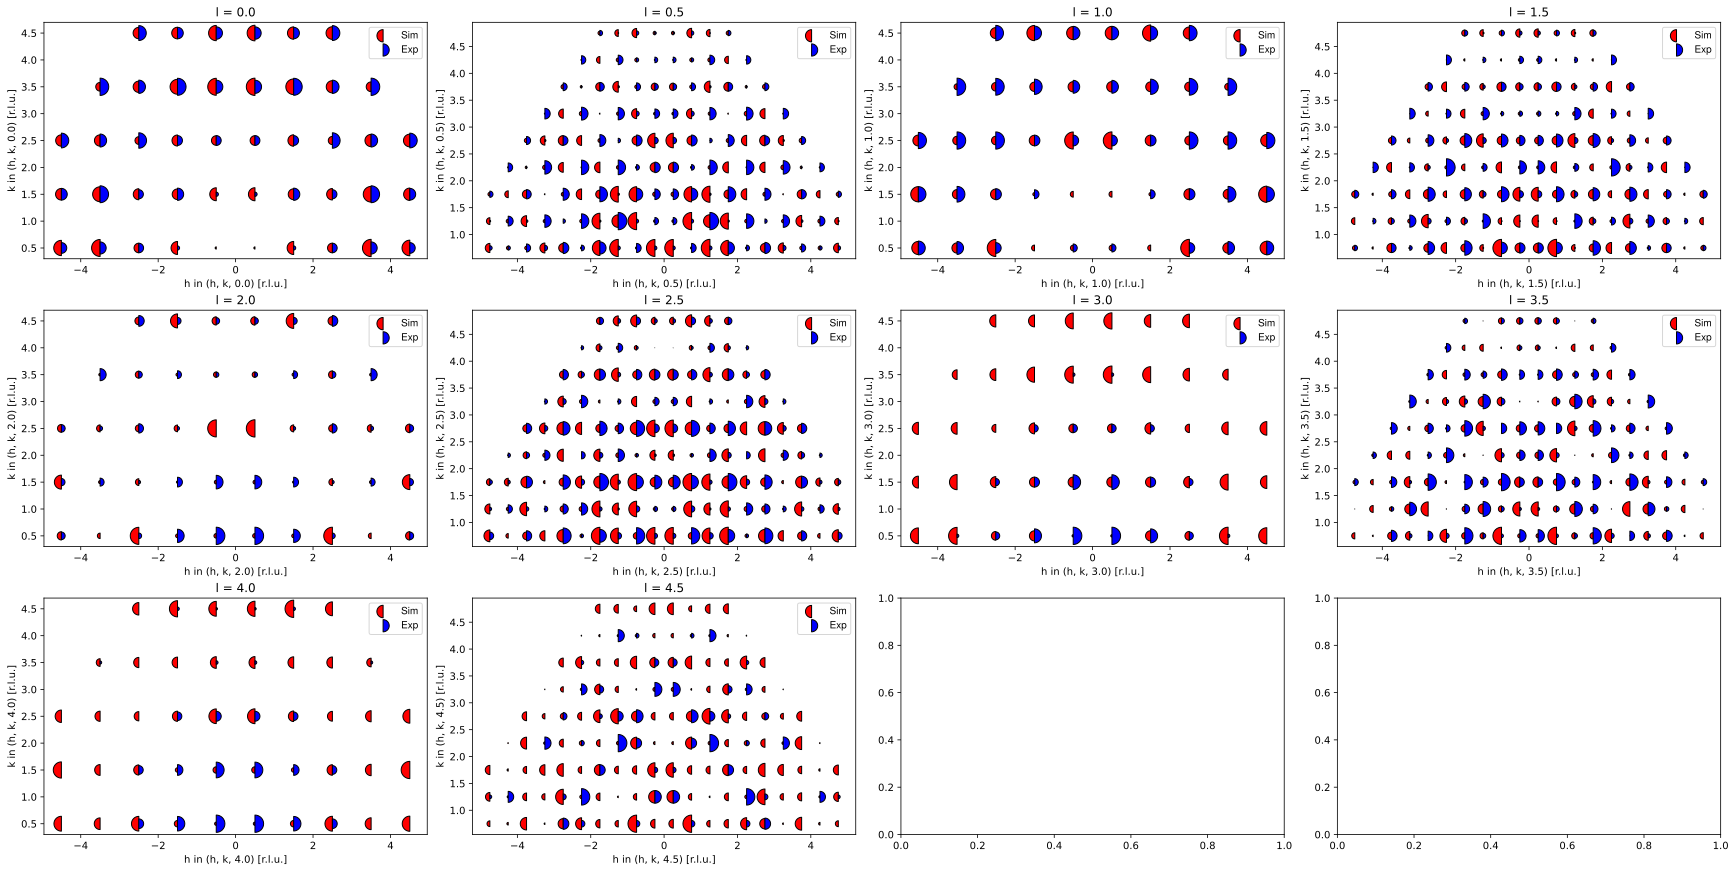

In [18]:
# Prepare subplot grid
l_values = np.arange(0, 5, 0.5)
n = len(l_values)
ncols = int(np.ceil(n / 3))
fig, axs = plt.subplots(3, ncols, figsize=(6 * ncols, 12), constrained_layout=True)

# Flatten axs in case it's 2D array
axs = axs.flatten()

plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Plot all subplots
for i, l in enumerate(l_values):
    plot_plane_sim_vs_exp(axs[i], exp_data, l, norm_plane=True)

plt.show()

